# Описание проекта

Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.
Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты. 

# Описание данных

<b>Данные для первой части</b>

Файл '/datasets/hypothesis.csv':
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

<b>Данные для второй части</b>

Файл '/datasets/orders.csv':
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

Файл '/datasets/visitors.csv':
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

# Ход работы:

[1. Импорт библиотек, загрузка датасетов](#import)

[2. Приоритизация гипотез:](#priority)
- [2.1. фреймворк ICE](#ice)
- [2.2. фреймворк RICE](#rice)
- [2.3. вывод](#conclusion_1)

[3. Анализ A/B теста](#analysis)

[3.1. Расчет кумулятивных значений:](#cumulative)
- график кумулятивной выручки по группам;
- график кумулятивного среднего чека по группам;
- график относительного изменения кумулятивного среднего чека группы B к группе A;
- график кумулятивного среднего количества заказов на посетителя по группам;
- график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A;


[3.2. Точечная оценка и перцентили:](#scatter_and_perc)
- точечный график количества заказов по пользователям;
- 95-й и 99-й перцентили количества заказов на пользователя;
- точечный график стоимостей заказов;
- 95-й и 99-й перцентили стоимости заказов;
- [вывод](#conclusion_3)

[3.3. Статистическая значимость различий:](#stat_sign)
- [3.3.1. проверка гипотезы № 1 - статистически значимых различий в среднем количестве заказов между группами нет](#hypotesis_1)
- [3.3.2. посчитаем стат. значимость по "сырым" данным](#raw_1)
- [3.3.3. посчитаем стат. значимость по "очищенным" данным](#clear_1)
- [вывод (гипотеза № 1);](conclusion_4)

- [3.3.4. проверка гипотезы № 2 - статистически значимых различий в среднем чеке заказа между группами нет:](#hypotesis_2)
- [3.3.5. посчитаем стат. значимость по "сырым" данным](#raw_2)
- [3.3.6. посчитаем стат. значимость по "очищенным" данным](#clear_2)
- [вывод (гипотеза № 2)](conclusion_5)

[Общий вывод](#conclusion_6)

[Решение](#decision)

<a id="import"> </a>
# 1. Импорт библиотек, загрузка датасетов

In [8]:
# импортируем библиотеки

import pandas as pd
import numpy as np
from scipy import stats as st
import datetime as dt

import matplotlib.pyplot as plt

In [9]:
# загружаем датасеты

hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

In [10]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [11]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [12]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Для исследования нам доступно три датасета - hypothesis, orders и visitors.

Датафрейм hypothesis - 9 строк, 5 колонок, пропущенных значений - нет. Необходимо изменить стиль написания названий столбцов (с маленькой буквы).

Датафрейм orders - 1197 строк, 5 колонок, пропущенных значений - нет. Необходимо изменить стиль написания названий столбцов  'transaction Id' и 'visitor Id' (snake case вместо camel case).

Датафрейм visitors - 62 строки, 3 колонки, пропущенных значений - нет.

В дальнейшем в столбцах 'date' в датафреймах 'orders' и 'visitors' необходимо изменить тип данных.

<a id="priority"> </a>
# 2. Приоритизация гипотез.

В датасете 'hypothesis' 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.

In [13]:
pd.options.display.max_colwidth = 130
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [14]:
hypothesis.columns = [x.lower() for x in hypothesis.columns]

In [15]:
# выделим список гипотез с номерами для удобства

h_list = [[hypothesis.index[i], hypothesis['hypothesis'][i]] for i in range(0, len(hypothesis))]
h_list

[[0,
  'Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей'],
 [1,
  'Запустить собственную службу доставки, что сократит срок доставки заказов'],
 [2,
  'Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа'],
 [3,
  'Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар'],
 [4,
  'Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей'],
 [5,
  'Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов'],
 [6,
  'Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию'],
 [7,
  'Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок'],
 [8, 'Запустить акцию, дающую скидку на товар в день рождения']]

<a id="ice"> </a>
# 2.1. Фреймворк ICE

<img src='https://pictures.s3.yandex.net/resources/ice_score_2-27da3b9e-15cd-4f96-91a4-fefffd1d986e_1569198107.jpg' width=320, heigth=240>


In [16]:
hypothesis['ice'] = round((hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts'], 2)
hypothesis.sort_values(by='ice', ascending=False).head(3)

,hypothesis,reach,impact,confidence,efforts,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20


<a id="rice"> </a>
# 2.2. Фреймворк RICE

<img src='https://pictures.s3.yandex.net/resources/rice_score_1634305501.png' width=320, heigth=240>

In [17]:
hypothesis['rice'] = round((hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts'], 2)
hypothesis.sort_values(by='rice', ascending=False).head(3)

,hypothesis,reach,impact,confidence,efforts,ice,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0


<a id="conclusion_1"> </a>
# 2.3. Вывод
Приоритезировав гипотезы фреймворком ICE, мы выделили топ-3 гипотезы:
- № 8 - 'Запустить акцию, дающую скидку на товар в день рождения' (ICE - 16.2);
- № 0 - 'Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей' (ICE - 13.3),
- № 7 - 'Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок' (ICE - 11.2).


Воспользовавшись фрйемворком RICE, в топ-3 вышли гипотезы:
- № 7 - 'Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок' (RICE - 112);
- № 2 - 'Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа' (RICE - 56.0);
- № 0 - 'Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей' (RICE - 40.0).

Разница приоритетов можно объяснить формулов расчета: отличие RICE от ICE в том, что при расчете RICE в знаменатель добавляют параметр Reach, показывающий охват пользователей при введение каких-либо изменений. Чем больше охват - тем выше RICE. Восьмая гипотеза, имеющая самое большое значение ICE, не вошла в топ RICE из-за слишком маленьких охватов. Это логично, т.к. гипотеза связана не со всеми пользователями, а только с теми, кто в ближайшие дни отмечает день рождения.

<a id="analysis"> </a>
# 3. Анализ A/B теста.

In [73]:
# изменим стиль написания названий столбцов 'transaction Id' и 'visitor Id' (snake case вместо camel case)

orders.columns = ['transaction_id', 'visitor_id', 'date', 'revenue', 'group']

In [74]:
# изменим тип данных

orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [75]:
orders.head(3)

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A


In [76]:
# изменим тип данных

visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [77]:
visitors.head(3)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507


In [23]:
# проверка на явные дубликаты

print(visitors.duplicated().sum(), orders.duplicated().sum())

visitors = visitors.drop_duplicates()
orders = orders.drop_duplicates()

0 0


In [78]:
# общая информация об A/B тесте

print(f"количество групп в A/B тесте: {visitors['group'].nunique()}")
print(f"временной интервал A/B теста: {visitors['date'].min()} - {visitors['date'].max()}")

количество групп в A/B тесте: 2
временной интервал A/B теста: 2019-08-01 00:00:00 - 2019-08-31 00:00:00


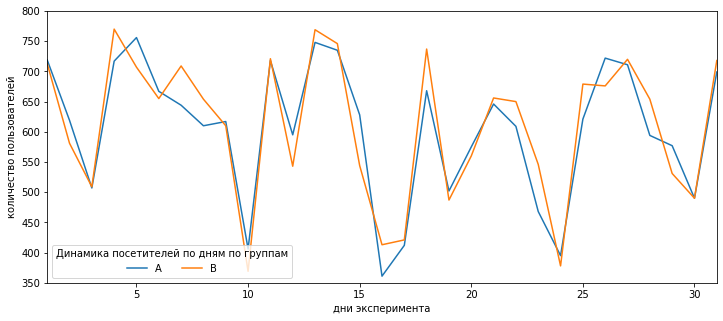

In [210]:
# динамика посетителей по дням по группам 

group_a = pd.DataFrame(visitors[visitors['group']=='A'].groupby('date')['visitors'].sum()).reset_index()
group_b = pd.DataFrame(visitors[visitors['group']=='B'].groupby('date')['visitors'].sum()).reset_index()

group_a['day'] = group_a['date'].dt.day
group_b['day'] = group_b['date'].dt.day

plt.figure(figsize=(12,5))
plt.plot(group_a['day'], group_a['visitors'], label='A')
plt.plot(group_b['day'], group_b['visitors'], label='B')
plt.axis([1, 31, 350, 800])
plt.xlabel('дни эксперимента')
plt.ylabel('количество пользователей')
plt.legend(title='Динамика посетителей по дням по группам', loc='lower left', ncol = 2);

In [86]:
# количество пользователей в каждой группе 

orders['group'].value_counts()

B    640
A    557
Name: group, dtype: int64

In [87]:
# проверим соотношение выборок
orders['group'].value_counts(normalize=True)

B    0.53467
A    0.46533
Name: group, dtype: float64

In [17]:
# проверим соотношение выборок

visitors['group'].value_counts(normalize=True)

A    0.5
B    0.5
Name: group, dtype: float64

Изучив процентное соотношение, мы видим что пользователи изначально делились на две группы по 50%, но группа В совершала больше покупок (53.5% против 45.5%).

In [194]:
# проверка - попадают ли пользователи в обе группы теста
# если да, то сколько
# cоздадим таблицу для поиска двойников, найдем visitor_id таких пользователей

d = orders.copy()
d['double'] = orders[orders['group']=='A']['visitor_id'].isin(orders[orders['group']=='B']['visitor_id'])
d = d[['visitor_id', 'double']].query('double==True')

print(f"количество пользователей, попавших в обе группы теста: {d['double'].sum()}")

количество пользователей, попавших в обе группы теста: 89


Пользователи не должны попадать одновременно в две группы. В идеале - их нужно убрать из выборки

<a id="cumulative"> </a>
# 3.1. Расчет кумулятивных значений.

In [196]:
# создаем массив уникальных пар значений дат и групп теста

dates_groups = orders[['date', 'group']].drop_duplicates()
dates_groups.head(3)

,date,group
0,2019-08-15,B
2,2019-08-15,A
45,2019-08-16,A


In [197]:
# соберём агрегированные кумулятивные по дням данные о заказах

orders_aggregated = dates_groups.apply(lambda x: \
                                       orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
                                      .agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', \
                                            'visitor_id' : 'nunique', 'revenue' : 'sum'}), axis=1)\
                                      .sort_values(by=['date','group'])
orders_aggregated.head(3)

,date,group,transaction_id,visitor_id,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401


In [198]:
# соберём агрегированные кумулятивные по дням данные о посетителях интернет-магазина

visitors_aggregated = dates_groups.apply(lambda x: \
                                    visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]\
                                    .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1)\
                                    .sort_values(by=['date','group']) 
visitors_aggregated.head(3)

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338


In [199]:
# объединим данные в одну таблицу

cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

In [206]:
# проверим совпадают ли минимальная и максимальная даты в датафрейме cumulative_data с минимальной 
# и максимальной датой в исходных данных

print(cumulative_data['date'].min()==visitors['date'].min())
print(cumulative_data['date'].max()==visitors['date'].max())

True
True


In [207]:
# разделим исходный датафрейм на два (по группам теста)
# с кумулятивным количеством заказов и кумулятивной выручкой по дням

cumulatuve_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date', 'revenue', 'orders']]
cumulatuve_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date', 'revenue', 'orders']]

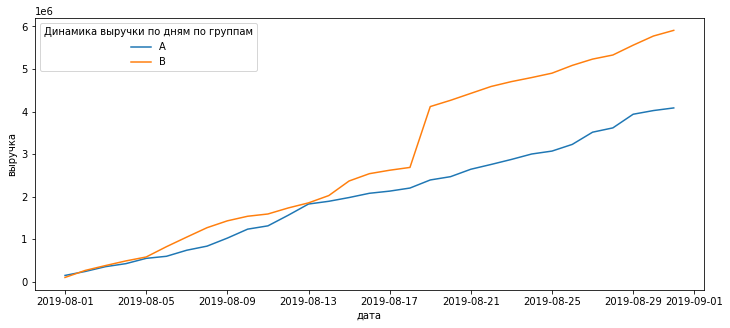

In [231]:
# строим график выручки по группам

plt.figure(figsize=(12,5))
plt.plot(cumulatuve_revenue_a['date'], cumulatuve_revenue_a['revenue'], label='A')
plt.plot(cumulatuve_revenue_b['date'], cumulatuve_revenue_b['revenue'], label='B')
plt.xlabel('дата')
plt.ylabel('выручка')
plt.legend(title='Динамика выручки по дням по группам');

На графике выручки по группам виден устойчивый рост выручки в обеих группах. Группа А растет стабильно, в группе В наблюдает всплеск и прирост выручки 18 августа. Возможно, это связано с нововведениями, которые простимулировали покупателей и увеличили конверсию. Либо в заказ попали аномально дорогие позиции.

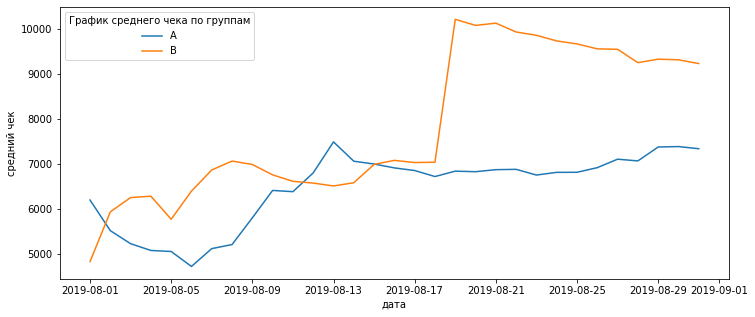

In [232]:
# строим график среднего чека по группам

plt.figure(figsize=(12,5))
plt.plot(cumulatuve_revenue_a['date'], cumulatuve_revenue_a['revenue']/cumulatuve_revenue_a['orders'], label='A')
plt.plot(cumulatuve_revenue_b['date'], cumulatuve_revenue_b['revenue']/cumulatuve_revenue_b['orders'], label='B')
plt.xlabel('дата')
plt.ylabel('средний чек')
plt.legend(title='График среднего чека по группам');

18 августа мы видим резкий скачок среднего чека в группе В. Это так же может быть связно с аномально дорогими товарами.

Средний чек группы А постепенно растет, средний чек группы В постепенно снижается, возможно, нужно больше данных для стабилизации.

In [233]:
# объединим датафреймы с кумулятивным количеством заказов и кумулятивной выручкой по дням, разбитые по группам

merged_cumulative_revenue = cumulatuve_revenue_a.merge(cumulatuve_revenue_b, left_on='date', 
                                                       right_on='date', how='left', suffixes=['A', 'B'])
merged_cumulative_revenue.head(3)

,date,revenueA,ordersA,revenueB,ordersB
0,2019-08-01,148579,24,101217,21
1,2019-08-02,242401,44,266748,45
2,2019-08-03,354874,68,380996,61


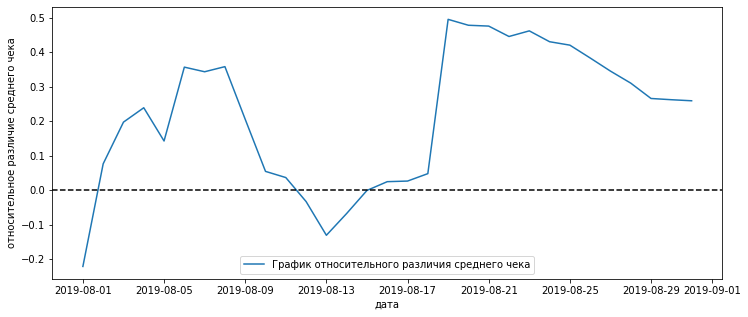

In [234]:
# строим график относительного различия среднего чека

plt.figure(figsize=(12,5))
plt.plot(merged_cumulative_revenue['date'], 
        (merged_cumulative_revenue['revenueB']/merged_cumulative_revenue['ordersB']) / 
         (merged_cumulative_revenue['revenueA']/merged_cumulative_revenue['ordersA']) - 1,
        label='График относительного различия среднего чека')

plt.xlabel('дата')
plt.ylabel('относительное различие среднего чека')
plt.legend(loc='lower center')
plt.axhline(y=0, color='black', linestyle='--');

Мы видим скачки на графике относительного различия среднего чека. Их так же можно объяснить выбросами.

In [225]:
# посчитаем конверсию посетителей в заказы
# разделим датафрейм на две группы

cumulative_data['conversion'] = cumulative_data['orders'] / cumulative_data['visitors']

cumulative_data_a = cumulative_data[cumulative_data['group']=='A']
cumulative_data_b = cumulative_data[cumulative_data['group']=='B']

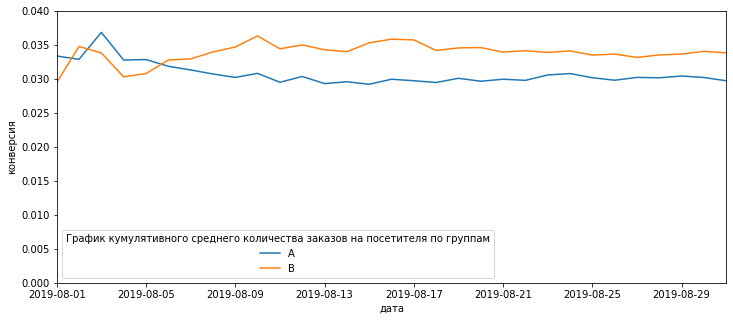

In [235]:
# построим график кумулятивного среднего количества заказов на посетителя по группам

plt.figure(figsize=(12,5))
plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label='B')
plt.legend()
plt.axis([cumulative_data_a['date'].min(), cumulative_data_a['date'].max(), 0, 0.04])

plt.xlabel('дата')
plt.ylabel('конверсия')
plt.legend(title='График кумулятивного среднего количества заказов на посетителя по группам');

Мы наблюдаем скачок конверсии группы А в самом начале наблюдений, потом - снижение и выход на плато. Схожая ситуация в группе В - несколько скачков в самом начале, потом конверсия зафиксировалось.

In [236]:
# объединим данные о конверсии

merged_cumulative_conversions = cumulative_data_a[['date', 'conversion']].merge(cumulative_data_b[['date', 'conversion']], \
                                                        left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

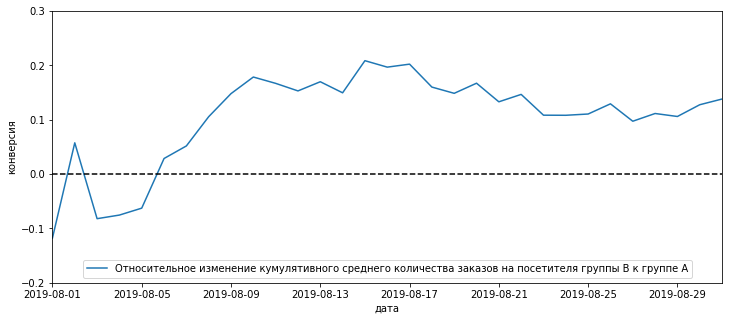

In [237]:
# построим график относительного изменения кумулятивного среднего количества заказов на посетителя по группам

plt.figure(figsize=(12,5))
plt.plot(merged_cumulative_conversions['date'], 
        merged_cumulative_conversions['conversionB'] / merged_cumulative_conversions['conversionA'] - 1,
        label='Относительное изменение кумулятивного среднего количества заказов на посетителя группы В к группе А')
plt.legend(loc='lower center')
plt.xlabel('дата')
plt.ylabel('конверсия')

plt.axhline(y=0, color='black', linestyle='--')
plt.axis([cumulative_data_a['date'].min(), cumulative_data_a['date'].max(), -0.2, 0.3]);

В начале наблюдений конверсия группы В была неустойчивая, затем стала расти. К концу наблюдений конверсия немного стабилизировалась, но "хвост" графика намекает на возможность роста. Возможно, нужно больше данных для стабилизации.

<a id="scatter_and_perc"> </a>

# 3.2. Точечная оценка и перцентили

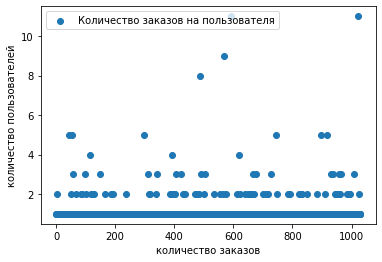

In [248]:
# построим точечный график количества заказов на пользователя

orders_by_user = orders.groupby('visitor_id')['transaction_id'].count()
x_values = pd.Series(range(0, len(orders_by_user)))

plt.scatter(x_values, orders_by_user, label = 'Количество заказов на пользователя')
plt.legend(loc='upper left')
plt.xlabel('количество заказов')
plt.ylabel('количество пользователей');

In [32]:
# посчитаем 95 и 99 перцентили количества заказов на пользователя

np.percentile(orders_by_user, [95, 99])

array([2., 4.])

<a id="conclusion_3"> </a>
На точечном графике количества заказов на пользователя мы увидели, что большая часть покупателей совершила одну-две покупки, скученную группу точек мы так же наблюдаем на отметке в три покупки. 95 перцентиль "проходит" по двум покупкам.


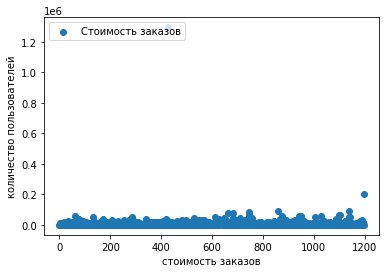

In [258]:
# построим точечный график стоимости заказа (без ограничений)

x_values = pd.Series(range(0, len(orders['revenue'])))

plt.scatter(x_values, orders['revenue'], label = 'Стоимость заказов')
plt.legend(loc='upper left')
plt.xlabel('стоимость заказов')
plt.ylabel('количество пользователей');

In [34]:
# посчитаем 95 и 99 перцентили стоимости заказа

np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

(0.0, 58233.2)

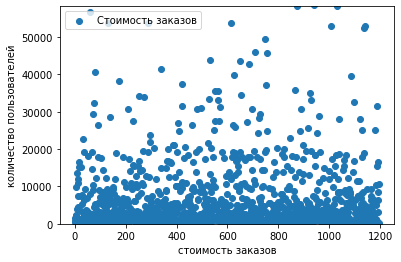

In [259]:
# построим точечный график стоимости заказа (ограниченный до 99 перцентиля)

x_values = pd.Series(range(0, len(orders['revenue'])))

plt.scatter(x_values, orders['revenue'], label = 'Стоимость заказов')
plt.legend(loc='upper left')
plt.xlabel('стоимость заказов')
plt.ylabel('количество пользователей');
plt.ylim((0, 58233.2))

95 и 99 перцентили стоимости заказа "проходят" по 28000 руб. и  58233.2 руб., соотвественно.

Для дальнейшей работы выделим группу аномальных покупателей, совершивших более трех покупок и чьи траты составили более 30000 руб.

<a id="stat_sign"> </a>

# 3.3. Статистическая значимость различий

# Гипотезы

Нам необходимо проверить <b>два предположения</b> - о различии в среднем количестве заказов на посетителя между группами и о различиях в среднем чеке заказа между группами. Оба предположения будут проверяться по "сырым" и "очищенным" от аномальных значений данным.

На основе <b>первого предположения</b> о различии в среднем количестве заказов на посетителя между группами, мы можем сформулировать две гипотезы: 
- H0: x̅1 = x̅2

Основная: статистически значимых различий в среднем количестве заказов между группами нет.
- и H1: x̅1 ≠ x̅2

Альтернативная: статистически значимые различия в среднем количестве заказов между группами есть.

И на основе <b>второго предположения</b> (о различиях в среднем чеке заказа между группами):
- H0: x̅1 = x̅2

Основная: статистически значимых различий в в среднем чеке заказа между группами нет.
- и H1: x̅1 ≠ x̅2
Альтернативная: статистически значимые различия в в среднем чеке заказа между группами есть.


<a id="hypotesis_1"> </a>
# 3.3.1. Гипотеза № 1 - статистически значимых различий в среднем количестве заказов между группами нет.

In [35]:
# сгруппируем количество пользователей по датам и группам
# переименуем столбцы 

visitors_daily_a = visitors[visitors['group']=='A'][['date', 'visitors']]
visitors_daily_b = visitors[visitors['group']=='B'][['date', 'visitors']]

visitors_daily_a.columns = ['date', 'visitors_per_date_a']
visitors_daily_b.columns = ['date', 'visitors_per_date_b']

In [36]:
# посчитаем посетителей по датам и группам с накоплением
# переименуем столбцы 

visitors_cumulative_a = visitors_daily_a.apply(lambda x: visitors_daily_a[visitors_daily_a['date'] <= x['date']]
                                            .agg({'date': 'max', 'visitors_per_date_a': 'sum'}), axis=1)

visitors_cumulative_b = visitors_daily_b.apply(lambda x: visitors_daily_b[visitors_daily_b['date'] <= x['date']]
                                            .agg({'date': 'max', 'visitors_per_date_b': 'sum'}), axis=1)

visitors_cumulative_a.columns = ['date', 'visitors_cumulative_a']
visitors_cumulative_b.columns = ['date', 'visitors_cumulative_b']

In [37]:
# сгруппируем количество заказов по датам и группам
# переименуем столбцы 

orders_daily_a = (orders[orders['group']=='A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
                 .groupby('date', as_index=False).agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'}))
orders_daily_b = (orders[orders['group']=='B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
                 .groupby('date', as_index=False).agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'}))

orders_daily_a.columns = ['date', 'orders_per_date_a', 'revenue_per_date_a']
orders_daily_b.columns = ['date', 'orders_per_date_b', 'revenue_per_date_b']

In [38]:
# посчитаем количество заказов по датам и группам с накоплением
# переименуем столбцы 

orders_cumulative_a = orders_daily_a.apply(lambda x: orders_daily_a[orders_daily_a['date'] <= x['date']]
                                            .agg({'date': 'max', 'orders_per_date_a': 'sum'}), axis=1)
orders_cumulative_b = orders_daily_b.apply(lambda x: orders_daily_b[orders_daily_b['date'] <= x['date']]
                                            .agg({'date': 'max', 'orders_per_date_b': 'sum'}), axis=1)

orders_cumulative_a.columns = ['date', 'orders_cumulative_a']
orders_cumulative_b.columns = ['date', 'orders_cumulative_b']

In [260]:
# объединяем получившиеся датафреймы в один

#data = (orders_daily_a.merge(orders_daily_b, left_on='date', right_on='date', how='left')
#                      .merge(orders_cumulative_a, left_on='date', right_on='date', how='left')
#                      .merge(orders_cumulative_b, left_on='date', right_on='date', how='left')
#                      .merge(visitors_daily_a, left_on='date', right_on='date', how='left')
#                      .merge(visitors_daily_b, left_on='date', right_on='date', how='left')
#                      .merge(visitors_cumulative_a, left_on='date', right_on='date', how='left')
#                      .merge(visitors_cumulative_b, left_on='date', right_on='date', how='left')
#       )

In [41]:
# создадим переменные в которых укажем число совершенных заказов для пользователей, которые 
# заказали хотя бы раз
# переименуем столбцы 

orders_by_users_a = (orders[orders['group'] == 'A'].groupby('visitor_id', as_index=False)
                                                .agg({'transaction_id': pd.Series.nunique}))
orders_by_users_b = (orders[orders['group'] == 'B'].groupby('visitor_id', as_index=False)
                                                .agg({'transaction_id': pd.Series.nunique}))

orders_by_users_a.columns = ['visitor_id', 'orders']
orders_by_users_b.columns = ['visitor_id', 'orders']

<a id="raw_1"> </a>

# 3.3.2. Посчитаем стат. значимость по "сырым" данным

In [42]:
# объявим переменные sample_a и sample_b, в которых пользователям из разных групп будет соответствовать 
# количество заказов. Тем, кто ничего не заказал, будут соответствовать нули

sample_a = pd.concat([orders_by_users_a['orders'],pd.Series(0, 
                                                         index=np.arange(data['visitors_per_date_a'].sum() - 
                                                         len(orders_by_users_a['orders'])), name='orders')], axis=0)

sample_b = pd.concat([orders_by_users_b['orders'],pd.Series(0, 
                                                         index=np.arange(data['visitors_per_date_b'].sum() - 
                                                         len(orders_by_users_b['orders'])), name='orders')], axis=0)


In [43]:
print('p-value (сырые данные): {0:.3f}'.format(st.mannwhitneyu(sample_a, sample_b)[1]))

print('относительное изменение в среднем количестве заказов в группе B по отношению к группе A (сырые данные): {0:.3f}'
      .format(sample_b.mean() / sample_a.mean() - 1))

p-value (сырые данные): 0.017
относительное изменение в среднем количестве заказов в группе B по отношению к группе A (сырые данные): 0.138


<b>Гипотеза № 1</b> - Н0: статистически значимых различий в среднем количестве заказов между группами нет 

> Для дальнейшей работы примем пороговый уровень статистической значимости  в 0.05 (далее - "alpha").

В ходе проверки гипотезы № 1 на "сырых" данных мы получили значение p-value равное 0.017, что меньше принятого нами alpha, значит мы можем <b>отвергнуть нулевую гипотезу</b>.

Относительное изменение в среднем количестве заказов в группе B по отношению к группе A (на "сырых" данные) составляет 13.8%.

В шаге [3.2](#scatter_and_perc) мы выяснили, что 95 и 99 перцентили количества заказов - это 2 и 4 заказа, соответственно. На графике мы увидели скученность точек на отметке в три заказа. 

95 и 99 перцентили стоимости заказа - 28 000 и 58 233.2 рубля.

В качестве максимальных значений выберем 3 заказа и стоимость заказа в 30 000 рублей. Все остальное будем считать аномльными значениями.

In [44]:
# узнаем количество "аномальных" пользоваталей 

users_with_many_orders = pd.concat([orders_by_users_a[orders_by_users_a['orders'] > 3]['visitor_id'],
                                    orders_by_users_b[orders_by_users_b['orders'] > 3]['visitor_id']], axis=0)

users_with_expensive_orders = orders[orders['revenue'] > 30000]['visitor_id']

abnormal_users = (pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
                   .drop_duplicates()
                   .sort_values())

abnormal_users.shape[0]

57

В имеющемся датасете обнаружено 57 аномальных пользователей, которых мы выделим в отдельный датасет.

<a id="clear_1"> </a>

# 3.3.3. Посчитаем стат. значимость по "очищенным" данным

In [45]:
sample_filtered_a = pd.concat([orders_by_users_a[np.logical_not(orders_by_users_a['visitor_id'].isin(abnormal_users))]['orders'], 
    pd.Series(0, index=np.arange(data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])), name='orders')], axis=0)

In [46]:
sample_filtered_b = pd.concat([orders_by_users_b[np.logical_not(orders_by_users_b['visitor_id'].isin(abnormal_users))]['orders'], 
    pd.Series(0, index=np.arange(data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])), name='orders')], axis=0)

In [47]:
print('p-value (очищ. данные): {0:.3f}'.format(st.mannwhitneyu(sample_filtered_a, sample_filtered_b)[1]))

print('относительное изменение в среднем количестве заказов в группе B по отношению к группе A (очищ. данные): {0:.3f}'
      .format(sample_filtered_b.mean() / sample_filtered_a.mean() - 1))

p-value (очищ. данные): 0.018
относительное изменение в среднем количестве заказов в группе B по отношению к группе A (очищ. данные): 0.148


<a id="conclusion_4"> </a>
Проведем те же самые расчеты на "очищенных данных", убрав из выборки "аномальных пользователей".
Полученный p-value составляет 0.018, что так же меньше alpha, значит мы  все еще можем <b>отвергнуть нулевую гипотезу</b>.

Относительное изменение в среднем количестве заказов в группе B по отношению к группе A (на "очищенных" данных) составляет 14.8%.

Выросший процент относительного изменения может нам подсказать, что аномально большое (больше трех) количество заказов было в группе А.

<a id="hypotesis_2"> </a>

# 3.3.4. Гипотеза № 2 - статистически значимых различий в среднем чеке заказа между группами нет.

<a id="raw_2"> </a>

# 3.3.5. Посчитаем стат. значимость по "сырым" данным

In [48]:
print('p-value (сырые данные): {0:.3f}'.format(st.mannwhitneyu(orders[orders['group']=='A']['revenue'],
                                                orders[orders['group']=='B']['revenue'])[1]))


print('относительное изменение в среднем чеке заказа в группе B по отношению к группе A (сырые данные): {0:.3f}'
      .format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-value (сырые данные): 0.729
относительное изменение в среднем чеке заказа в группе B по отношению к группе A (сырые данные): 0.259


<b>Гипотеза № 2</b> - Н0: статистически значимых различий в среднем чеке заказа между группами нет.

Полученное на "сырых" данных p-value (0.729) больше, чем установленное нами alpha, значит, мы <b>не можем отвегнуть нулевую гипотезу </b> в пользу альтернативной.

Относительное изменение в чеке заказа в группе B по отношению к группе A (на "сырых" данные) составляет 25.9%.

<a id="clear_2"> </a>

# 3.3.6. Посчитаем стат. значимость по "очищенным" данным

In [49]:
print('p-value (очищ. данные): {0:.3f}'.format(st.mannwhitneyu(orders[np.logical_and(orders['group']=='A', 
                                                 np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'],
                                                 orders[np.logical_and(orders['group']=='B', 
                                                 np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'])[1]))


print('относительное изменение в среднем чеке заказа в группе B по отношению к группе A (очищ. данные): {0:.3f}'
                            .format(orders[np.logical_and(orders['group']=='B', 
                            np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'].mean() /
                            orders[np.logical_and(orders['group']=='A', 
                            np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'].mean()-1))

p-value (очищ. данные): 0.958
относительное изменение в среднем чеке заказа в группе B по отношению к группе A (очищ. данные): -0.020


<a id="conclusion_5"> </a>
Проведем те же самые расчеты на "очищенных данных", убрав из выборки "аномальных пользователей". Полученный p-value составляет 0.958, что так же больше alpha, значит мы все еще <b>не можем отвегнуть нулевую гипотезу </b> в пользу альтернативной.

Относительное изменение в среднем количестве заказов в группе B по отношению к группе A (на "очищенных" данных) составляет 14.8%.

Относительное изменение просело и составило - -2%.  Аномально дорогие заказы попали в группу В, что мы уже видели на графиках из раздела ["Расчет кумулятивных значений"](#cumulative)

<a id="conclusion_6"> </a>
# Общий вывод

Для исследования нам доступно три датасета - hypothesis, orders и visitors:
- датафрейм hypothesis - 9 строк, 5 колонок, пропущенных значений - нет;
- датафрейм orders - 1197 строк, 5 колонок, пропущенных значений - нет;
- датафрейм visitors - 62 строки, 3 колонки, пропущенных значений - нет.


Была выполнена предобработка:
- изменен тип данных в столбцах 'date' в датафреймах 'orders' и 'visitors';
- изменен стиль написания названий столбцов 'transaction Id' и 'visitor Id' (snake case вместо camel case) в датафрейме 'orders';
- изменен стиль написания названий столбцов (с маленькой буквы) в датафрейме 'hypothesis'. 

# Приоритезация гипотез.

В датасете 'hypothesis' содержит девять гипотез:
- № 0 - 'Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей',
- № 1 - 'Запустить собственную службу доставки, что сократит срок доставки заказов',
- № 2 - 'Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа',
- № 3 - 'Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар',
- № 4 - 'Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей',
- № 5 - 'Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов',
- № 6 - 'Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию',
- № 7 - 'Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок',
- № 8 - 'Запустить акцию, дающую скидку на товар в день рождения'.

Данных гипотезы мы приоритезировали при помощи фреймворков ICE и RICE. 

Приоритезировав гипотезы фреймворком ICE, мы выделили топ-3 гипотезы:
- № 8 - 'Запустить акцию, дающую скидку на товар в день рождения' (ICE - 16.2);
- № 0 - 'Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей' (ICE - 13.3),
- № 7 - 'Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок' (ICE - 11.2).

Воспользовавшись фрйемворком RICE, в топ-3 вышли гипотезы:
- № 7 - 'Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок' (RICE - 112);
- № 2 - 'Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа' (RICE - 56.0);
- № 0 - 'Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей' (RICE - 40.0).

Разница приоритетов можно объяснить формулой расчета: отличие RICE от ICE в том, что при расчете RICE в знаменатель добавляют параметр Reach, показывающий охват пользователей при введение каких-либо изменений. Чем больше охват - тем выше RICE. Восьмая гипотеза, имеющая самое большое значение ICE, не вошла в топ RICE из-за слишком маленьких охватов. Это логично, т.к. гипотеза связана не со всеми пользователями, а только с теми, кто в ближайшие дни отмечает день рождения.

# Анализ A/B теста.
# Расчет кумулятивных значений.

В самом начале анализа мы изучили процентное соотношение групп А и В. Все пользователи (датафрейм 'visitors') изначально делили на две группы по 50%, но группа В совершала больше покупок (53.5% против 45.5% в датафрейме 'orders').

Построив график выручки по группам, мы увидели устойчивый рост выручки в обеих группах. Группа А расла стабильно, в группе В наблюдался всплеск и прирост выручки 18 августа. Возможно, это связано с нововведениями, которые простимулировали покупателей и увеличили конверсию. Либо в заказ попали аномально дорогие позиции.

Построив график среднего чека по группе мы увидели схожую картину: 18 августа был резкий скачок среднего чека в группе В. Это так же могло быть связно с покупкой аномально дорогих товаров.

Средний чек группы А постепенно рос к концу наблюдений, средний чек группы В постепенно снижался, возможно, нужно больше данных для стабилизации.

Построив график относительного различия среднего чека, мы так же увидели скачки на графике, которые можно объяснить появление аномально дорогих выбросов.

Построив график кумулятивного среднего количества заказов на посетителя по группам, мы увидели скачок конверсии группы А в самом начале наблюдений, потом - снижение и выход на плато. Схожая ситуация наблюдалась в группе В - несколько скачков в самом начале, потом конверсия зафиксировалось.

Построив график относительного изменения кумулятивного среднего количества заказов на посетителя по группам, в начале наблюдений мы увидели, что конверсия группы В была неустойчивая, затем стала расти. К концу наблюдений конверсия немного стабилизировалась, но "хвост" графика намекает на возможность роста. Возможно, нужно больше данных для стабилизации.

# Точечная оценка и перцентили

На точечном графике количества заказов на пользователя мы увидели, что большая часть покупателей совершила одну-две покупки, скученную группу точек мы так же наблюдаем на отметке в три покупки. 95 перцентиль "проходит" по двум покупкам.

95 и 99 перцентили стоимости заказа "проходят" по 28000 руб. и 58233.2 руб., соотвественно. Таких пользователей в датасете мы выделили 57 человек.

# Гипотезы

Мы проверяли два предположения - о различии в среднем количестве заказов на посетителя между группами и о различиях в среднем чеке заказа между группами. Оба предположения проверялись на "сырых" и "очищенных" от аномальных значений данных.

На основе первого предположения о различии в среднем количестве заказов на посетителя между группами, мы сформулировали две гипотезы:

- H0: x̅1 = x̅2
Основная: статистически значимых различий в среднем количестве заказов между группами нет.

- и H1: x̅1 ≠ x̅2
Альтернативная: статистически значимые различия в среднем количестве заказов между группами есть.

И на основе второго предположения (о различиях в среднем чеке заказа между группами):

- H0: x̅1 = x̅2
Основная: статистически значимых различий в в среднем чеке заказа между группами нет.

- и H1: x̅1 ≠ x̅2 Альтернативная: статистически значимые различия в в среднем чеке заказа между группами есть.

<b>Гипотеза № 1</b> - Н0: статистически значимых различий в среднем количестве заказов между группами нет 

В ходе проверки гипотезы № 1 на "сырых" данных мы получили значение p-value равное 0.017, что меньше принятого нами alpha (0.05), значит мы можем <b>отвергнуть нулевую гипотезу</b>.

Относительное изменение в среднем количестве заказов в группе B по отношению к группе A (на "сырых" данные) составляет 13.8%.

Мы провели те же расчеты на "очищенных данных", убрав из выборки "аномальных пользователей". Полученный p-value составил 0.018, что так же меньше alpha, значит мы все еще можем <b>отвергнуть нулевую гипотезу</b>. Статистически значимых различий в среднем количестве заказов между группами есть.

Относительное изменение в среднем количестве заказов в группе B по отношению к группе A (на "очищенных" данных) составляет 14.8%.

Выросший процент относительного изменения может нам подсказать, что аномально большое (больше трех) количество заказов было в группе А.

<b>Гипотеза № 2</b> - Н0: статистически значимых различий в среднем чеке заказа между группами нет.

Полученное на "сырых" данных p-value (0.729) больше, чем установленное нами alpha, значит, мы <b>не можем отвегнуть нулевую гипотезу </b> в пользу альтернативной, значит, статистически значимых различий  в среднем чеке заказа между группами нет.

Относительное изменение в чеке заказа в группе B по отношению к группе A (на "сырых" данные) составляет 25.9%.

Проведем те же самые расчеты на "очищенных данных", убрав из выборки "аномальных пользователей". Полученный p-value составляет 0.958, что так же больше alpha, значит мы все еще <b>не можем отвегнуть нулевую гипотезу </b> в пользу альтернативной.

Относительное изменение в среднем количестве заказов в группе B по отношению к группе A (на "очищенных" данных) составляет 14.8%.

Относительное изменение просело и составило - -2%.  Аномально дорогие заказы попали в группу В, что мы уже видели на графиках из раздела ["Расчет кумулятивных значений"](#cumulative)

<a id="decision"> </a>
# Решение:

1. статистически значимые различия в среднем количестве заказов есть:
- p-value на сырых данных - 0.017
- p-value на очищенных данных - 0.018

относительное изменение в среднем количестве заказов в группе B по отношению к группе A: 
- сырые данные - 13.8%
- очищенные данные - 14.8%


2. статистически значимых различий в среднем чеке заказа между группами нет: 
- p-value на сырых данных - 0.729
- p-value на очищенных данных - 0.958

относительное изменение в среднем чеке заказа в группе B по отношению к группе A: 
- сырые данные - 25.9%
- очищенные данные -2%

<b>Группа В статистически лучше группы А. Тест стоит остановить.</b>